# Change date

In [1]:
date = '2017-04-28'

In [2]:
from pathlib import Path
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from skimage.transform import rotate
import scipy.optimize as so
from collections import namedtuple

In [4]:
from heatmap import heatmap48

In [5]:
dir_ = Path(date)

In [6]:
savefigdir = Path(dir_, 'figures')
savefigdir.mkdir(parents=True, exist_ok=True)
    
def figure(x=None, y=None, scale=1):
    if x is None:
        x = ncols
    if y is None:
        y = nrows
    plt.subplots(figsize=(scale*x, scale*y))
    
save_figures = False

def savefig(filename, **kwargs):
    if not save_figures:
        return
    import os
    kwargs_ = dict(dpi=300, bbox_inches='tight')
                   #frameon=True, facecolor='white', transparent=False)
    kwargs_.update(kwargs)
    out_fname = Path(savefigdir, date + '_' + filename)
    plt.savefig(str(out_fname), **kwargs_)
    print('Saved: %s' % out_fname)

In [7]:
[f for f in dir_.glob('*.png')]

[WindowsPath('2017-04-28/conf10_R_11x11_647LP_200ms.png'),
 WindowsPath('2017-04-28/conf10_R_11x11_647LP_200ms2.png'),
 WindowsPath('2017-04-28/conf10_R_11x11_647LP_200ms3_darkspot.png'),
 WindowsPath('2017-04-28/conf10_R_11x11_647LP_200ms_reall_far_close_mirrors.png'),
 WindowsPath('2017-04-28/conf10_R_11x11_647LP_200ms_reall_far_close_mirrors2.png'),
 WindowsPath('2017-04-28/conf10_R_11x11_647LP_200ms_reall_far_close_mirrors3.png'),
 WindowsPath('2017-04-28/conf11_R_11x11_647LP_200ms.png'),
 WindowsPath('2017-04-28/conf12_R_11x11_647LP_200ms.png'),
 WindowsPath('2017-04-28/conf13_R_11x11_647LP_200ms.png'),
 WindowsPath('2017-04-28/conf14_R_11x11_647LP_200ms.png'),
 WindowsPath('2017-04-28/conf14_R_11x11_647LP_200ms2.png'),
 WindowsPath('2017-04-28/conf14_R_4x12_647LP_200ms.png'),
 WindowsPath('2017-04-28/conf1_G_4x12_647LP_200ms.png'),
 WindowsPath('2017-04-28/conf1_R_4x12_647LP_200ms.png'),
 WindowsPath('2017-04-28/conf2_G_4x12_647LP_200ms.png'),
 WindowsPath('2017-04-28/conf2_R_4x1

# Change file names

In [8]:
#crop = (300, 1200)
crop = (400, 1100)

In [9]:
g = ndi.imread(date + '/conf9_G_4x12_647LP_200ms.png')[:, crop[0]:crop[1]]

r = ndi.imread(date + '/conf14_R_4x12_647LP_200ms.png')[:, crop[0]:crop[1]]

# Change rotation

In [10]:
rotation = -0.8

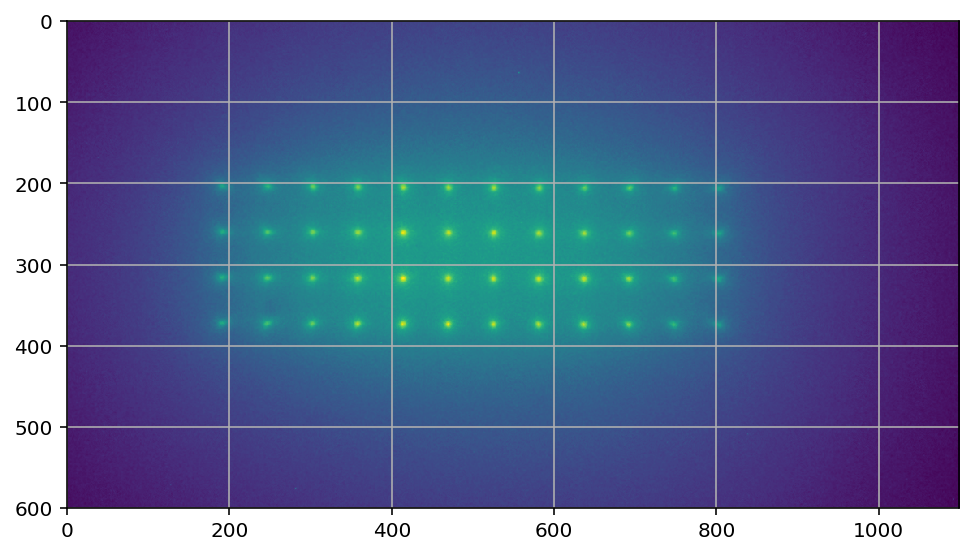

In [11]:
gr = rotate(g.T, rotation, preserve_range=True)[50:-50,50:-50]
gr -= gr.min()
plt.figure(figsize=(8, 6))
plt.imshow(gr)
plt.grid()

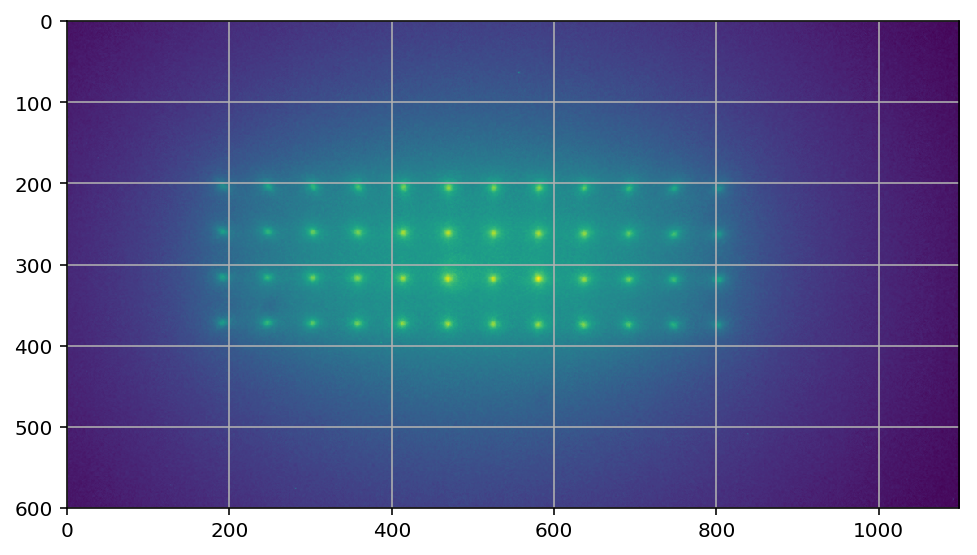

In [12]:
rr = rotate(r.T, rotation, preserve_range=True)[50:-50,50:-50]
rr -= rr.min()
plt.figure(figsize=(8, 6))
plt.imshow(rr)
plt.grid()

In [13]:
rrlp = ndi.gaussian_filter(rr, 40)
rrhp = rr - rrlp

In [14]:
grlp = ndi.gaussian_filter(gr, 40)
grhp = gr - grlp

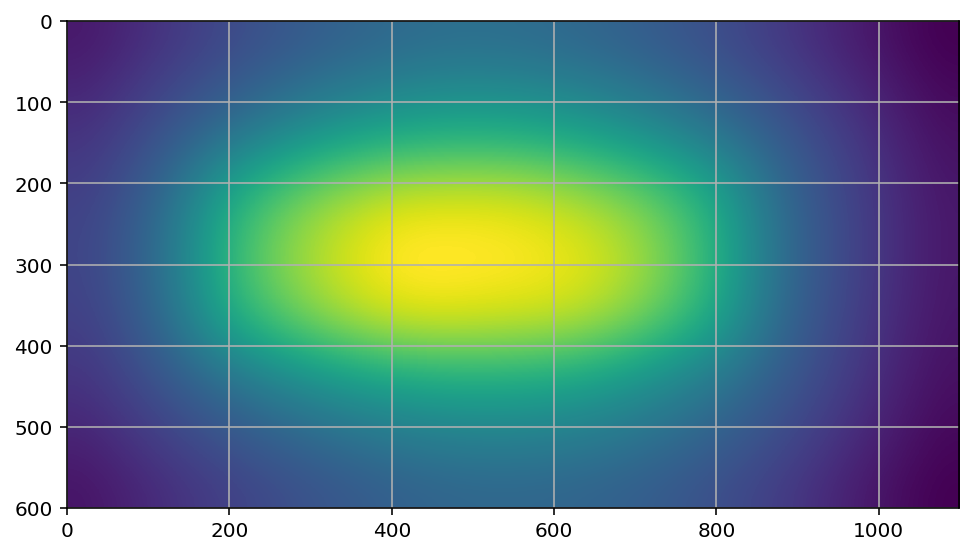

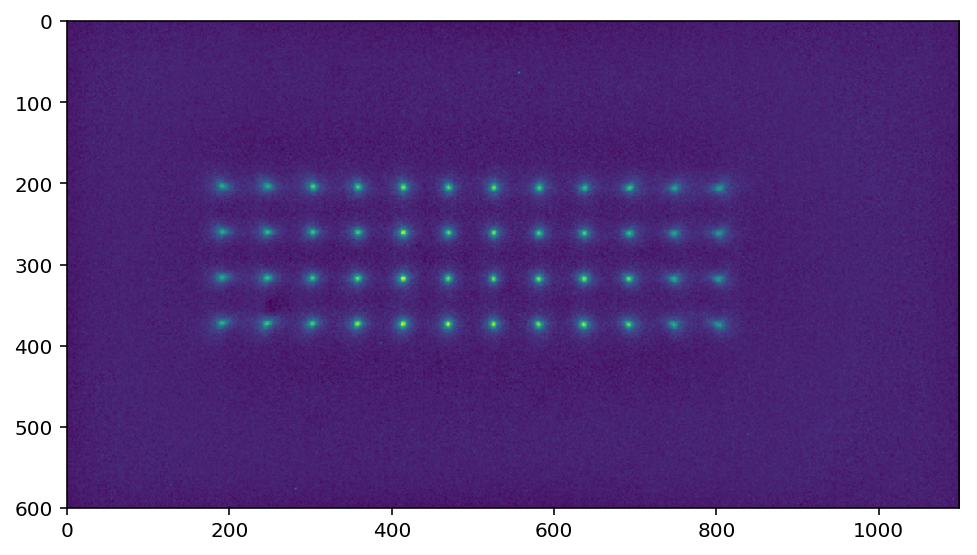

In [15]:
plt.figure(figsize=(8, 6))
plt.imshow(grlp)
plt.grid()
plt.figure(figsize=(8, 6))
plt.imshow(grhp);

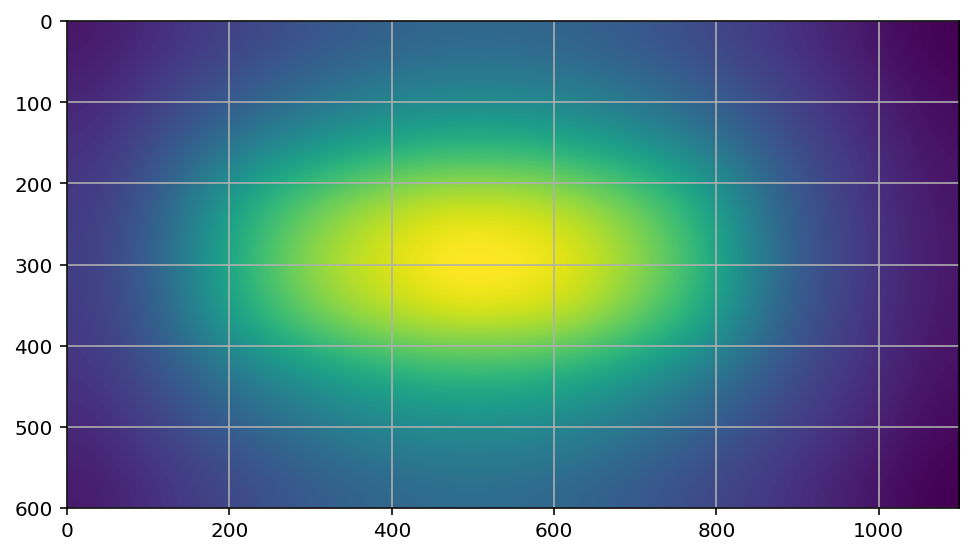

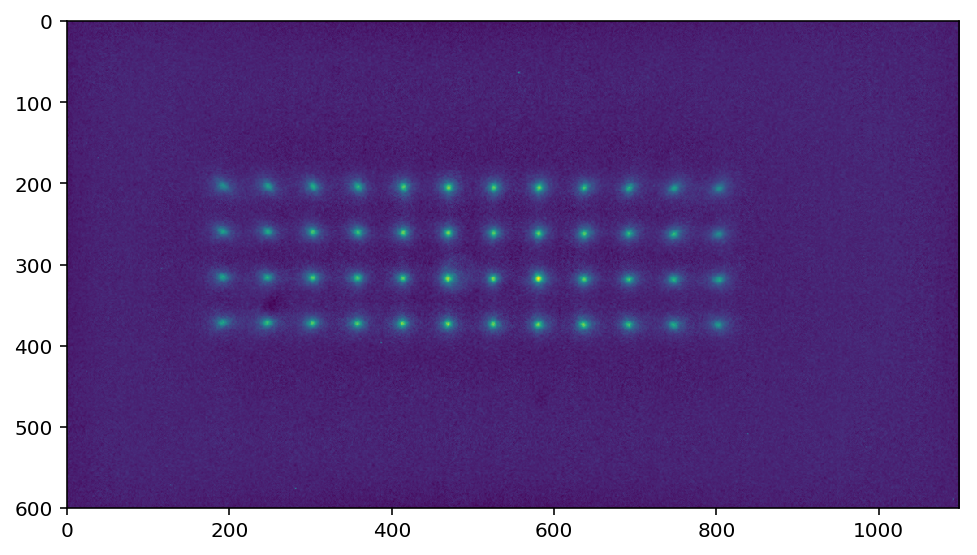

In [16]:
plt.figure(figsize=(8, 6))
plt.imshow(rrlp)
plt.grid()
plt.figure(figsize=(8, 6))
plt.imshow(rrhp);

$$f(x,y) = A \exp\left(- \left(a(x - x_o)^2 - 2b(x-x_o)(y-y_o) + c(y-y_o)^2 \right)\right)$$

$$a = \frac{\cos^2\theta}{2\sigma_x^2} + \frac{\sin^2\theta}{2\sigma_y^2}$$

$$b = -\frac{\sin2\theta}{4\sigma_x^2} + \frac{\sin2\theta}{4\sigma_y^2}$$

$$c = \frac{\sin^2\theta}{2\sigma_x^2} + \frac{\cos^2\theta}{2\sigma_y^2}$$

In [17]:
def gauss2d(x, y, mx=0, my=0, sx=1, sy=1, rot=0, A=1):
    θ = rot * np.pi / 180
    cos_sq = np.cos(θ)**2 
    sin_sq = np.sin(θ)**2
    sin_2t = np.sin(2*θ)
    dsx_sq = 2*sx**2
    dsy_sq = 2*sy**2
    a = cos_sq/dsx_sq + sin_sq/dsy_sq
    c = sin_sq/dsx_sq + cos_sq/dsy_sq
    b = - sin_2t/(2*dsx_sq) + sin_2t/(2*dsy_sq)
    xm = x - mx
    ym = y - my
    return A * np.exp(-(a*xm**2 - 2*b*xm*ym + c*ym**2))

In [18]:
def residuals(p, img):
    mx, my, sx, sy, rot = p
    X, Y = np.meshgrid(np.arange(0, img.shape[1]), np.arange(0, img.shape[0]))
    Z = gauss2d(X, Y, mx=mx, my=my, sx=sx, sy=sy, rot=rot) * img.max()
    return (Z - img).ravel()

In [19]:
Params = namedtuple('Params', 'mx my sx sy rot')

# Change xmin, ymin

In [20]:
xmin, ymin = 162, 175

In [21]:
pitch = 56
nrows = 4
ncols = 12
width = pitch * ncols
height = pitch * nrows
bounds_bbox_x = np.arange(ncols + 1)*pitch
bounds_bbox_y = np.arange(nrows + 1)*pitch
bounds_x = bounds_bbox_x + xmin
bounds_y = bounds_bbox_y + ymin
bounds_lx = bounds_bbox_x + pitch
bounds_ly = bounds_bbox_y + pitch
bbox = (slice(ymin, ymin + pitch * nrows),
        slice(xmin, xmin + pitch * ncols))
bboxl = (slice(ymin-pitch, ymin + pitch * (nrows + 1)),
         slice(xmin-pitch, xmin + pitch * (ncols + 1)))

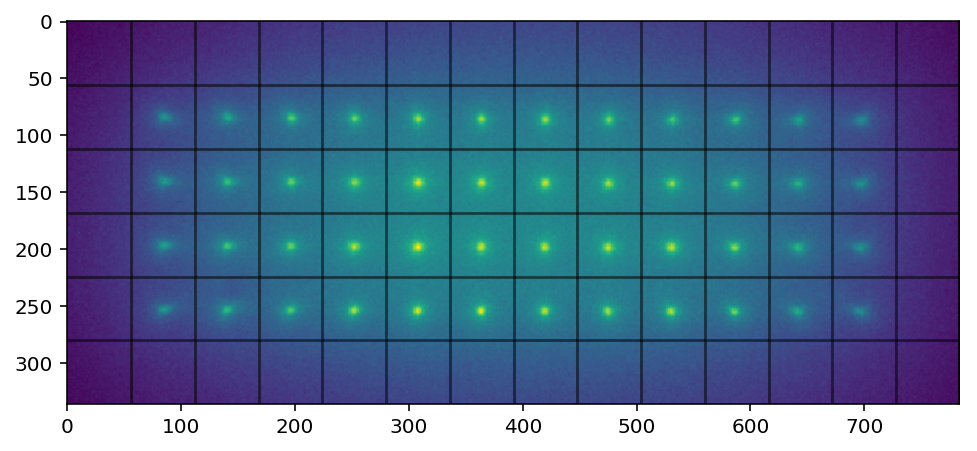

In [22]:
plt.figure(figsize=(8, 8))
plt.imshow(gr[bboxl], cmap='viridis')
for bx in bounds_lx:
    plt.axvline(bx, color='k', alpha=0.5)
for by in bounds_ly:
    plt.axhline(by, color='k', alpha=0.5)
plt.grid(False)

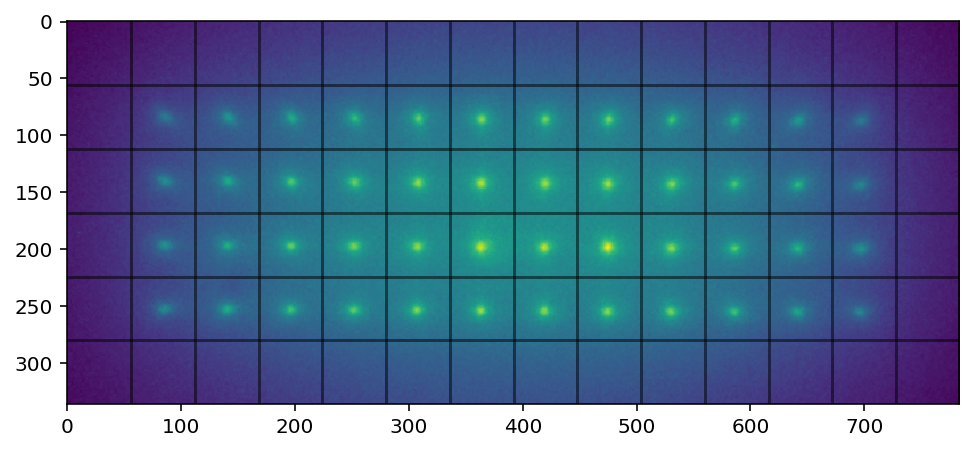

In [23]:
plt.figure(figsize=(8, 8))
plt.imshow(rr[bboxl], cmap='viridis')
for bx in bounds_lx:
    plt.axvline(bx, color='k', alpha=0.5)
for by in bounds_ly:
    plt.axhline(by, color='k', alpha=0.5)
plt.grid(False)

In [24]:
def iter_spot(img, bounds_x, bounds_y):
    for by1, by2 in zip(bounds_y[:-1], bounds_y[1:]):
        for bx1, bx2 in zip(bounds_x[:-1], bounds_x[1:]):
            yield img[by1:by2, bx1:bx2]

In [25]:
for spot in iter_spot(grhp, bounds_x, bounds_y):
    print(spot.shape, spot.max())
    break

(56, 56) 9725.19174179


In [26]:
shape = (pitch, pitch)
x, y = np.meshgrid(np.arange(0, shape[1]), np.arange(0, shape[0]))
Xm, Ym = np.meshgrid(np.arange(0, shape[1], 0.2), np.arange(0, shape[0], 0.2))

In [27]:
guess = Params(mx=pitch/2, my=pitch/2, sx=pitch/4, sy=pitch/4, rot=0)
guess

Params(mx=28.0, my=28.0, sx=14.0, sy=14.0, rot=0)

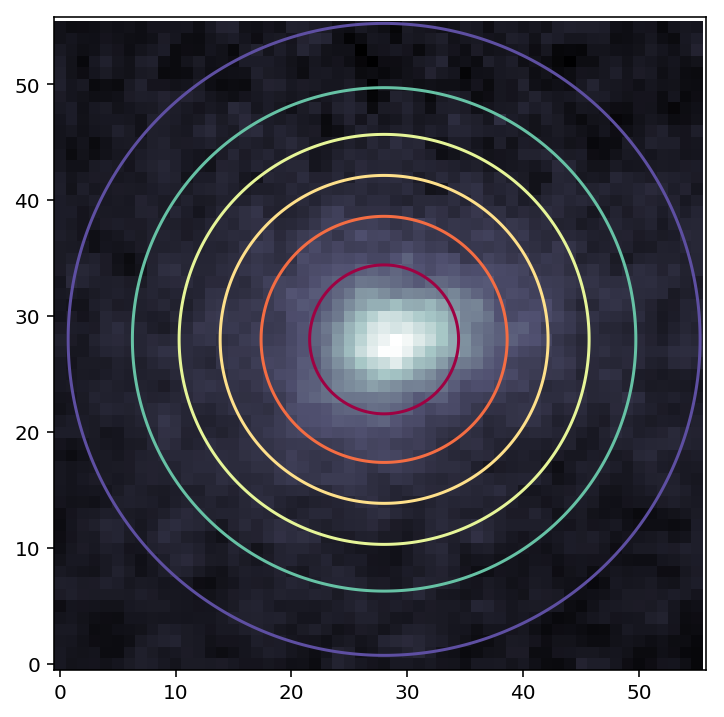

In [28]:
Z = gauss2d(Xm, Ym, *guess)

plt.figure(figsize=(6, 6))
plt.imshow(spot, interpolation='nearest', origin='lower', cmap='bone');
plt.contour(Xm, Ym, Z, 6, cmap='Spectral_r');

In [29]:
spotm = spot - spot.min()
res = so.least_squares(residuals, guess, kwargs=dict(img=spotm))
res.message, res.x, res.nfev, 

('`ftol` termination condition is satisfied.',
 array([ 29.0028311 ,  27.97849254,   8.70839289,   6.14957435,  13.68821341]),
 19)

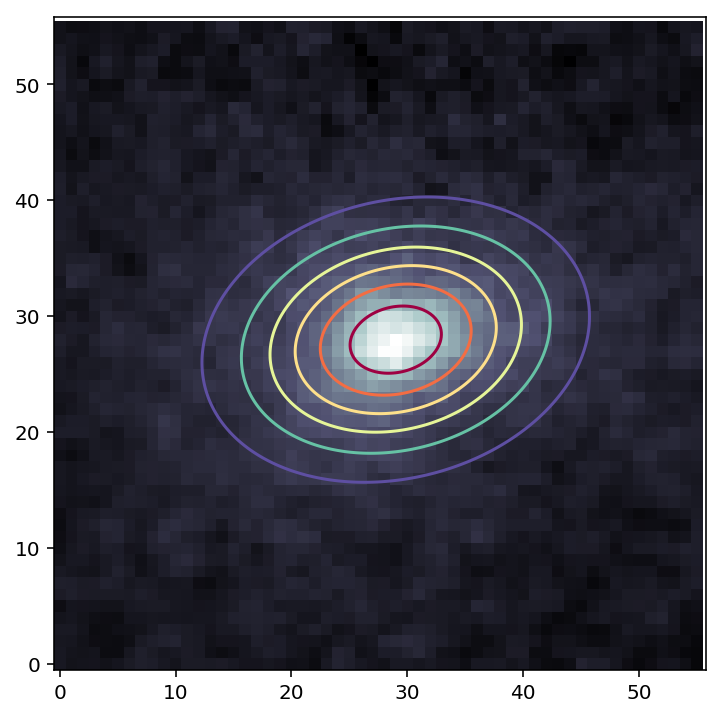

In [30]:
Z = gauss2d(Xm, Ym, *res.x)

plt.figure(figsize=(6, 6))
plt.imshow(spotm, interpolation='nearest', origin='lower', cmap='bone');
plt.contour(Xm, Ym, Z, 6, cmap='Spectral_r');
plt.grid(False)

In [31]:
ax = grhp
Res = np.zeros((nrows, ncols, 9))
Mess = []
Succ = []

for iy, (by1, by2) in enumerate(zip(bounds_y[:-1], bounds_y[1:])):
    for ix, (bx1, bx2) in enumerate(zip(bounds_x[:-1], bounds_x[1:])):
        spotm = ax[by1:by2, bx1:bx2] - ax[by1:by2, bx1:bx2].min()
        res = so.least_squares(residuals, guess, kwargs=dict(img=spotm))
        Mess.append(res.message)
        Succ.append(res.success)
        Res[iy, ix, :5] = res.x
        Res[iy, ix, 5] = ax[by1:by2, bx1:bx2].max()
        Res[iy, ix, 6] = gr[by1:by2, bx1:bx2].max()
        Res[iy, ix, 7] = ax[by1:by2, bx1:bx2].sum()
        Res[iy, ix, 8] = gr[by1:by2, bx1:bx2].sum()

In [32]:
ax = rrhp
ResR = np.zeros((nrows, ncols, 9))
MessR = []
SuccR = []

for iy, (by1, by2) in enumerate(zip(bounds_y[:-1], bounds_y[1:])):
    for ix, (bx1, bx2) in enumerate(zip(bounds_x[:-1], bounds_x[1:])):
        spotm = ax[by1:by2, bx1:bx2] - ax[by1:by2, bx1:bx2].min()
        res = so.least_squares(residuals, guess, kwargs=dict(img=spotm))
        MessR.append(res.message)
        SuccR.append(res.success)
        ResR[iy, ix, :5] = res.x
        ResR[iy, ix, 5] = ax[by1:by2, bx1:bx2].max()
        ResR[iy, ix, 6] = rr[by1:by2, bx1:bx2].max()
        ResR[iy, ix, 7] = ax[by1:by2, bx1:bx2].sum()
        ResR[iy, ix, 8] = rr[by1:by2, bx1:bx2].sum()

In [33]:
Mess[0]

'`ftol` termination condition is satisfied.'

In [34]:
MessR[0]

'`ftol` termination condition is satisfied.'

In [35]:
all(Succ), all(SuccR)

(True, True)

In [36]:
sum(Succ), sum(SuccR)

(48, 48)

In [37]:
all([Mess[0] == m for m in Mess])

True

In [38]:
all([MessR[0] == m for m in MessR])

True

In [39]:
Res.shape

(4, 12, 9)

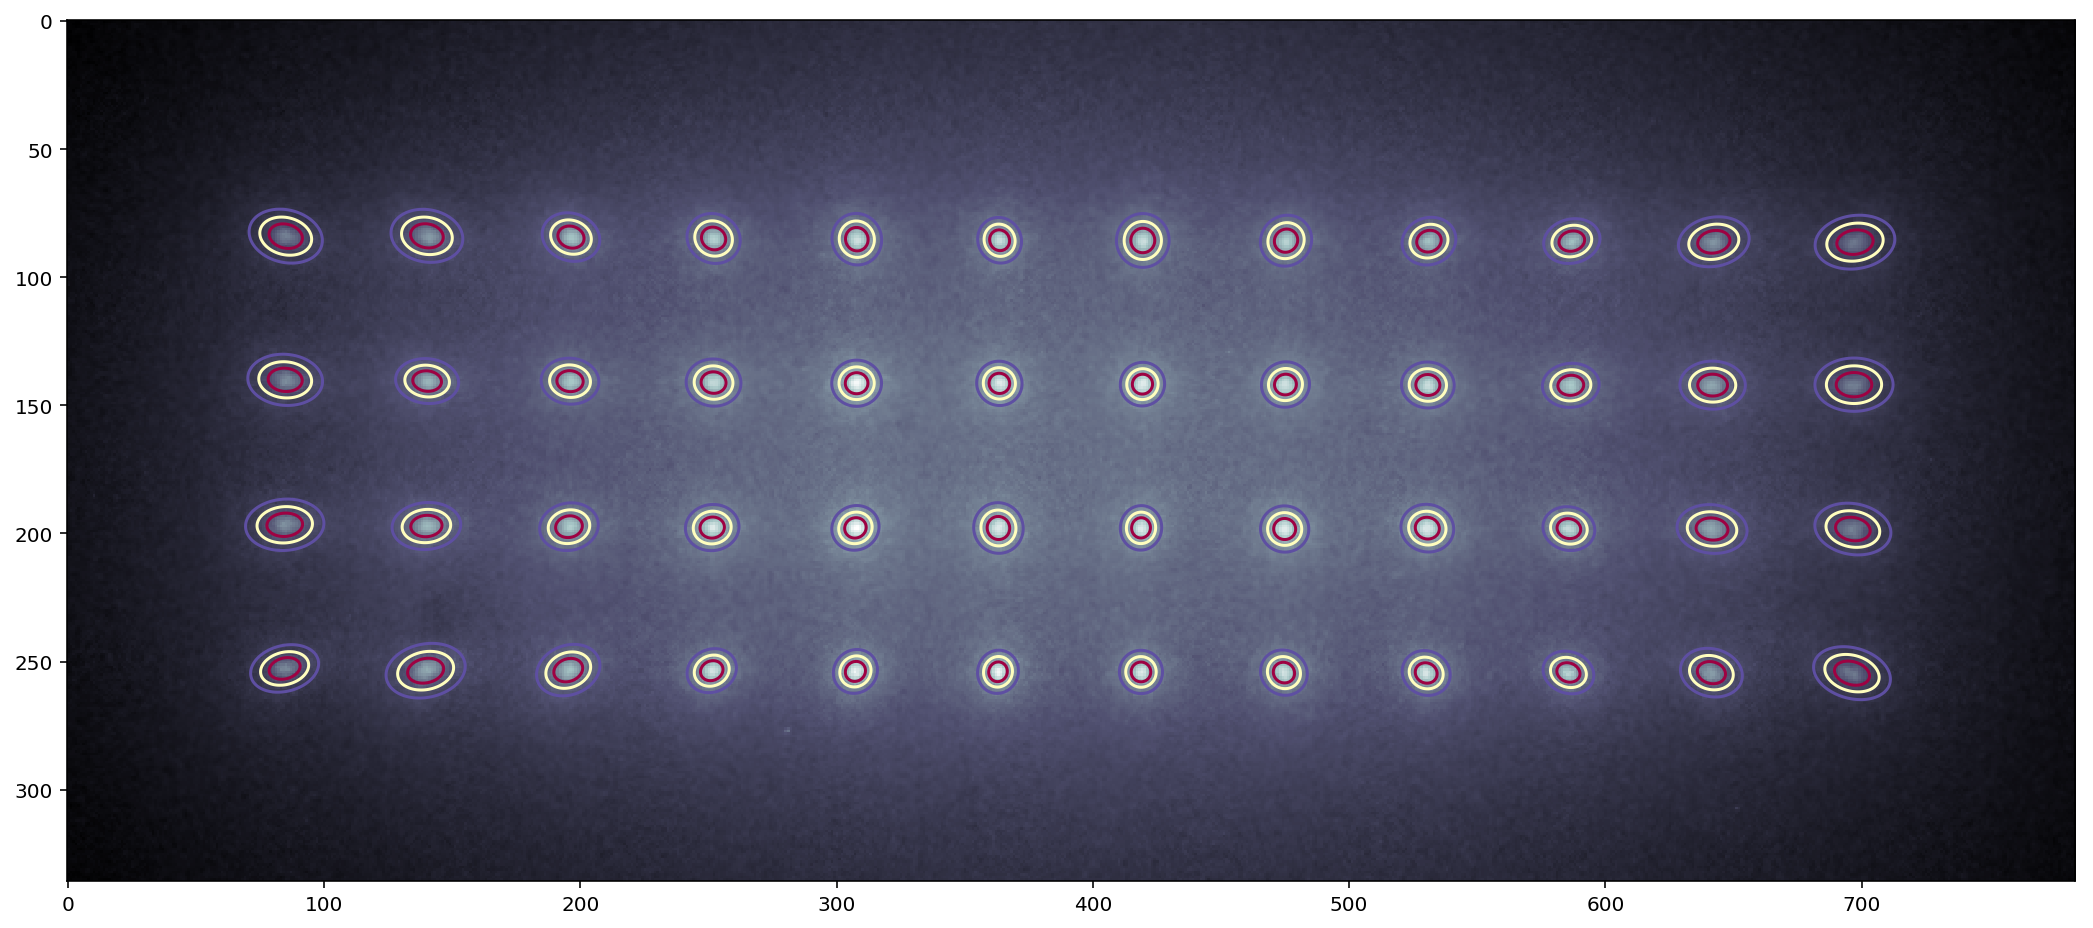

In [40]:
plt.figure(figsize=(18, 10))
plt.imshow(gr[bboxl], cmap='bone')

for ix, bx, in enumerate(bounds_lx[:-1]):
    for iy, by, in enumerate(bounds_ly[:-1]):
        Z = gauss2d(Xm, Ym, *Res[iy, ix, :5])
        plt.contour(Xm+bx, Ym+by, Z, 3, cmap='Spectral_r');
plt.grid(False)
savefig('Gpattern_bone_fit.png')

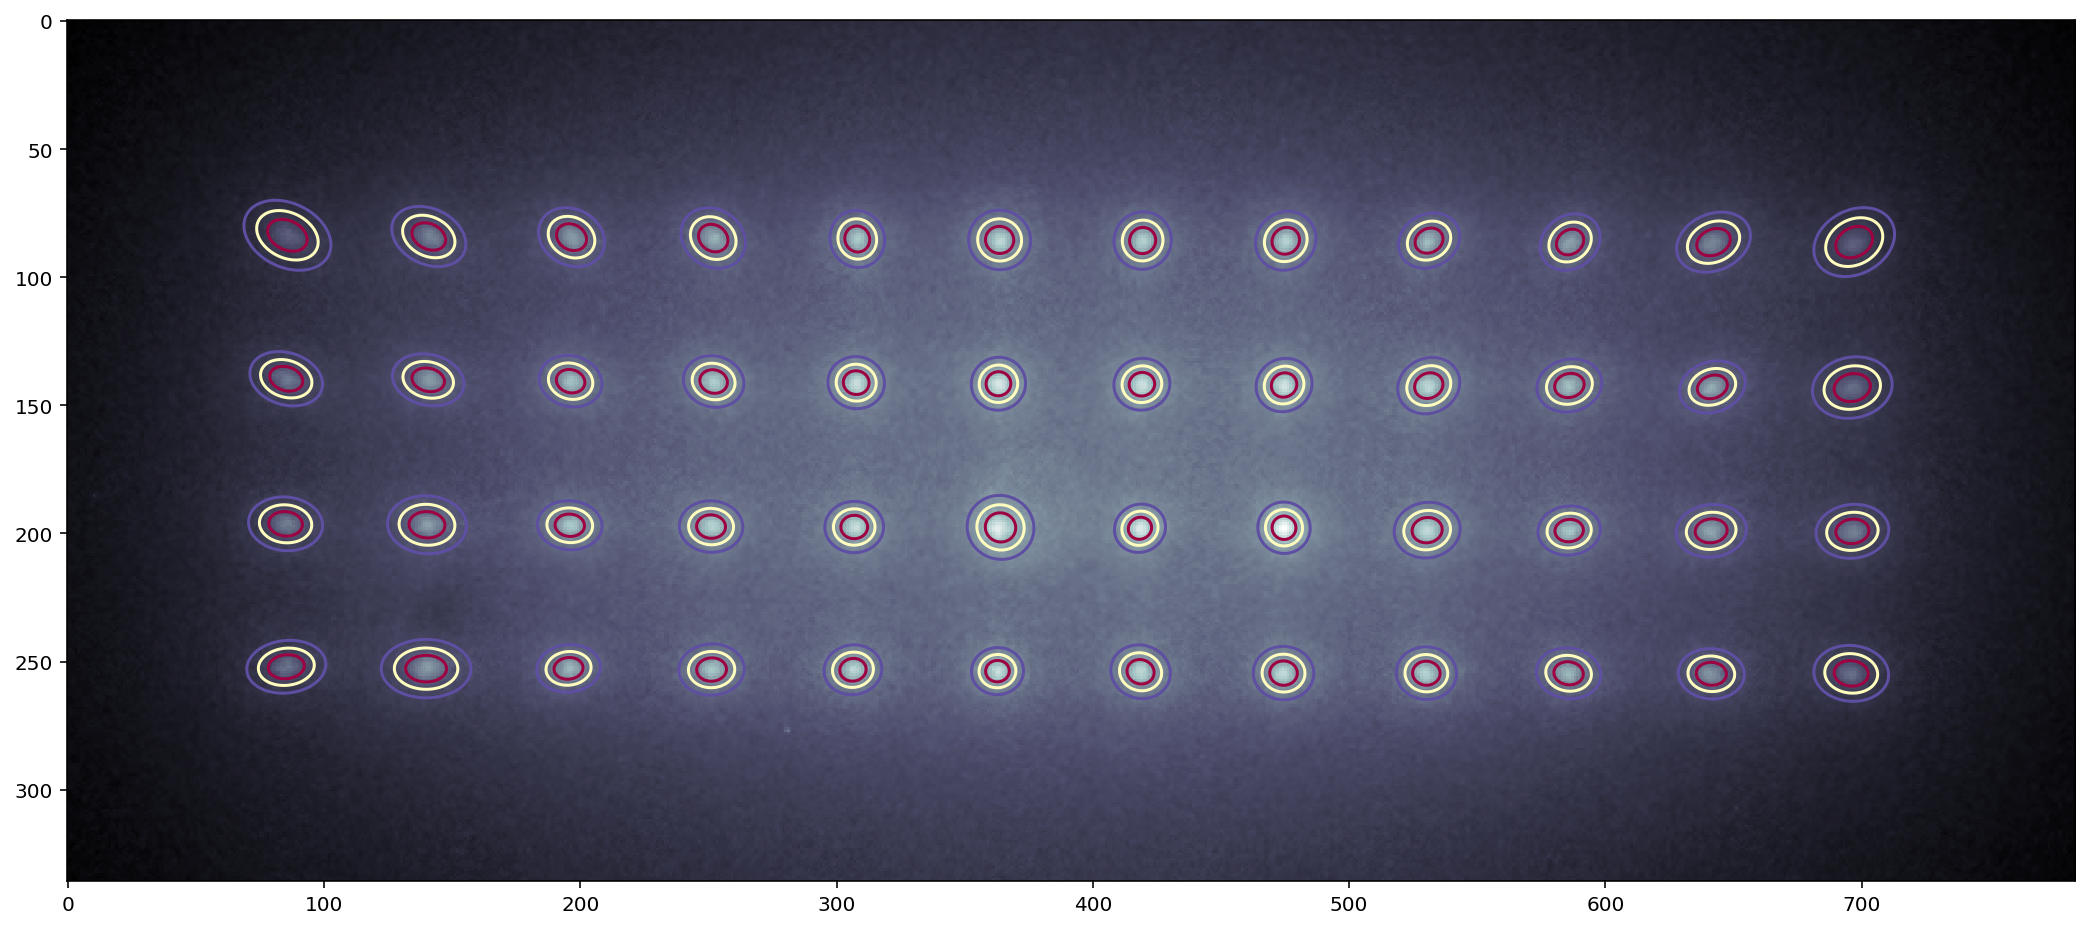

In [41]:
plt.figure(figsize=(18, 10))
plt.imshow(rr[bboxl], cmap='bone')

for ix, bx, in enumerate(bounds_lx[:-1]):
    for iy, by, in enumerate(bounds_ly[:-1]):
        Z = gauss2d(Xm, Ym, *ResR[iy, ix, :5])
        plt.contour(Xm+bx, Ym+by, Z, 3, cmap='Spectral_r');
plt.grid(False)
savefig('Rpattern_bone_fit.png')

In [42]:
def norm_angle(angle):
    """Fold input angle in the -180.. 180 range."""
    return (np.asfarray(angle) + 180) % 360 - 180

def fold_angle(angle):
    """Fold angle in the -90..90 range."""
    nangle = norm_angle(angle)
    nangle[nangle > 90] -= 180
    nangle[nangle < -90] += 180
    return nangle

In [43]:
norm_angle(np.arange(-380, 380, 20))

array([ -20.,    0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,
        160., -180., -160., -140., -120., -100.,  -80.,  -60.,  -40.,
        -20.,    0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,
        160., -180., -160., -140., -120., -100.,  -80.,  -60.,  -40.,
        -20.,    0.])

In [44]:
norm_angle([-360, -180, 180, 360])

array([   0., -180., -180.,    0.])

In [45]:
Res1 = Res.copy()
for iy in range(Res.shape[0]):
    for ix in range(Res.shape[1]):
        if Res[iy, ix, 2] < Res[iy, ix, 3]:
            Res1[iy, ix, 2], Res1[iy, ix, 3] = Res[iy, ix, 3], Res[iy, ix, 2]
            Res1[iy, ix, 4] = Res1[iy, ix, 4] - 90
Res1[:, :, 4] = fold_angle(Res1[:, :, 4])

In [46]:
ResR1 = ResR.copy()
for iy in range(ResR.shape[0]):
    for ix in range(ResR.shape[1]):
        if ResR[iy, ix, 2] < ResR[iy, ix, 3]:
            ResR1[iy, ix, 2], ResR1[iy, ix, 3] = ResR[iy, ix, 3], ResR[iy, ix, 2]
            ResR1[iy, ix, 4] = ResR1[iy, ix, 4] - 90
ResR1[:, :, 4] = fold_angle(ResR1[:, :, 4])

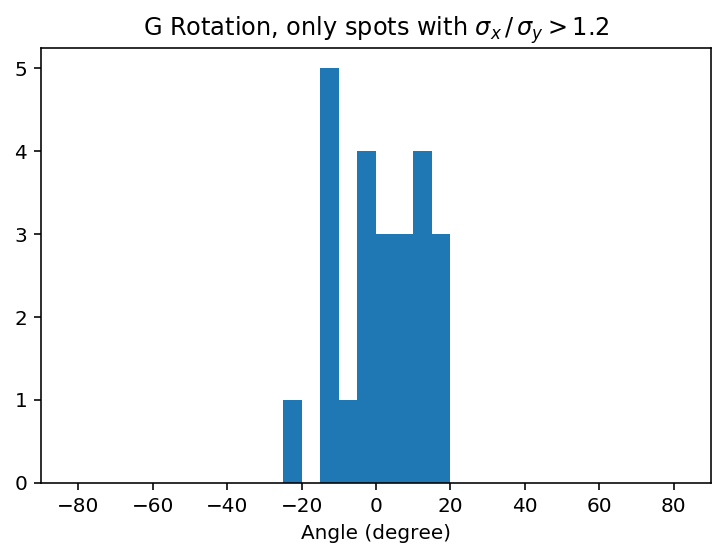

In [47]:
eccth = 1.2
ecc = Res1[:,:,2]/Res1[:,:,3]
valid = ecc >= eccth

bins = np.arange(-90, 90, 5)
plt.hist(Res1[:,:,4][valid].ravel(), bins=bins)
plt.title('G Rotation, only spots with $\sigma_x \,/\, \sigma_y > %.1f$' % eccth);
plt.xlabel('Angle (degree)')
plt.xlim(-90, 90)
savefig('G Rotation');

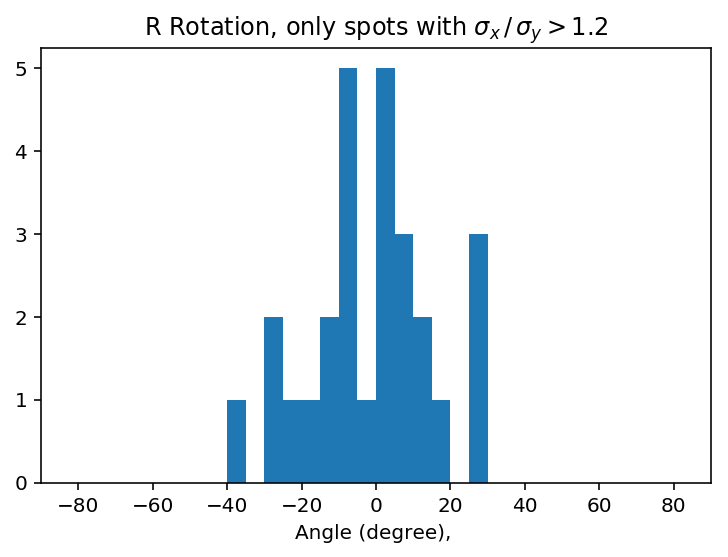

In [48]:
eccth = 1.2
eccR = ResR1[:,:,2]/ResR1[:,:,3]
valid = eccR >= eccth

bins = np.arange(-90, 90, 5)
plt.hist(ResR[:,:,4][valid].ravel(), bins=bins)
plt.xlabel('Angle (degree), ')
plt.xlim(-90, 90)
plt.title('R Rotation, only spots with $\sigma_x \,/\, \sigma_y > %.1f$' % eccth);
savefig('R Rotation');

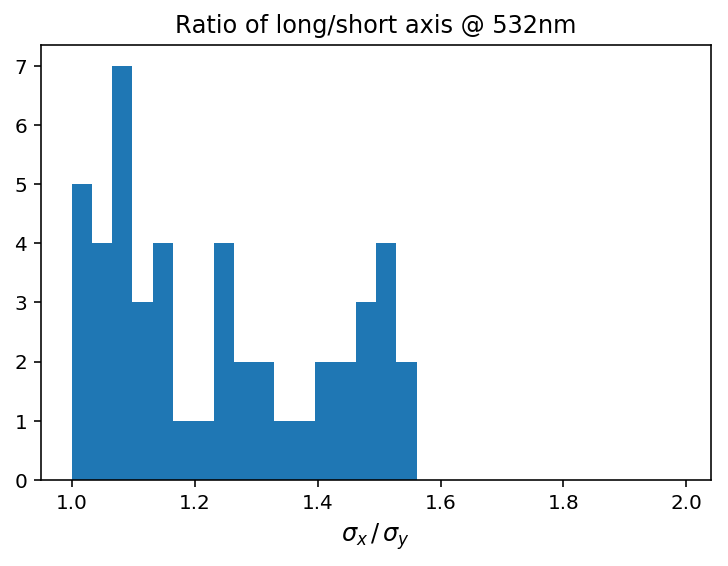

In [49]:
bins = np.arange(1, 2, 0.033)
plt.hist((Res1[:,:,2]/Res1[:,:,3]).ravel(), bins=bins)
plt.title('Ratio of long/short axis @ 532nm');
plt.xlabel('$\sigma_x \,/\, \sigma_y$', fontsize=12);
savefig('G Eccentricity');

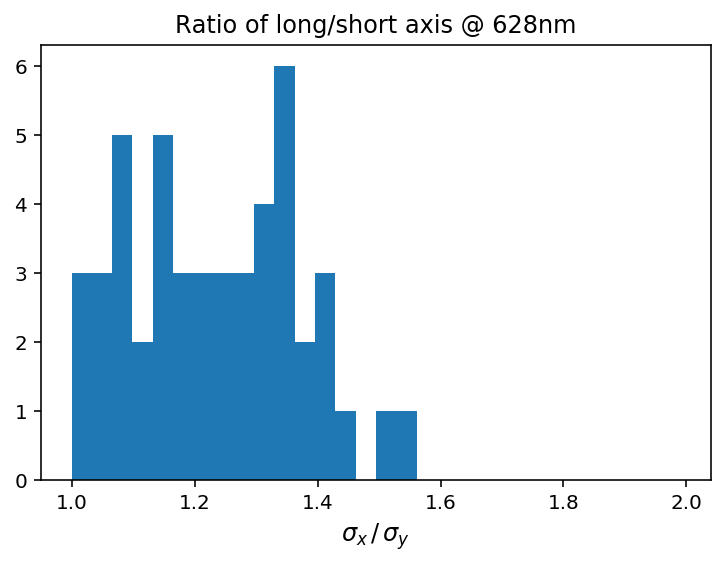

In [50]:
bins = np.arange(1, 2, 0.033)
plt.hist((ResR1[:,:,2]/ResR1[:,:,3]).ravel(), bins=bins)
plt.title('Ratio of long/short axis @ 628nm');
plt.xlabel('$\sigma_x \,/\, \sigma_y$', fontsize=12);
savefig('R Eccentricity');

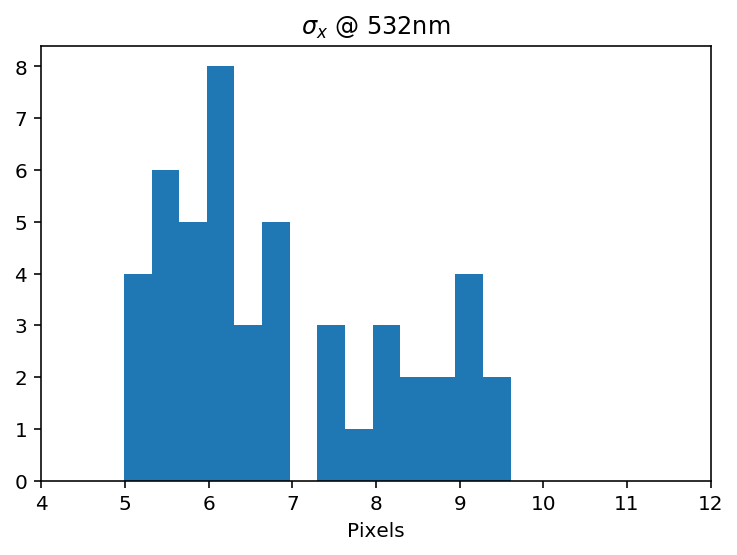

In [51]:
bins = np.arange(4, 15, 0.33)
plt.hist((Res1[:,:,2]).ravel(), bins=bins)
plt.xlim(4, 12)
plt.title('$\sigma_x$ @ 532nm');
plt.xlabel('Pixels')
savefig('G Sigma X');

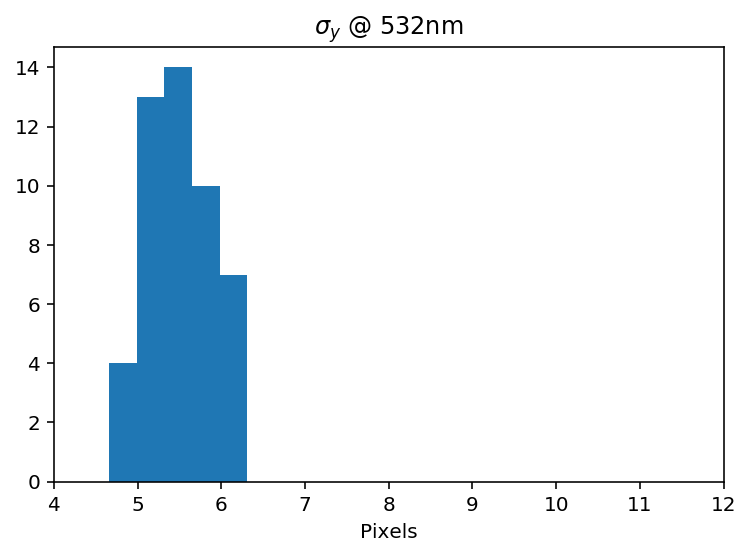

In [52]:
bins = np.arange(4, 15, 0.33)
plt.hist((Res1[:,:,3]).ravel(), bins=bins)
plt.xlim(4, 12)
plt.title('$\sigma_y$ @ 532nm');
plt.xlabel('Pixels')
savefig('G Sigma Y');

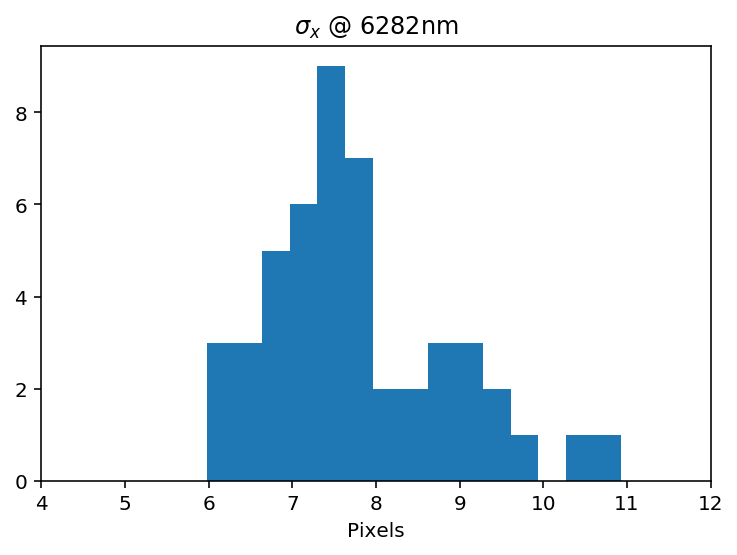

In [53]:
bins = np.arange(4, 15, 0.33)
plt.hist((ResR1[:,:,2]).ravel(), bins=bins)
plt.xlim(4, 12)
plt.title('$\sigma_x$ @ 6282nm');
plt.xlabel('Pixels')
savefig('R Sigma X');

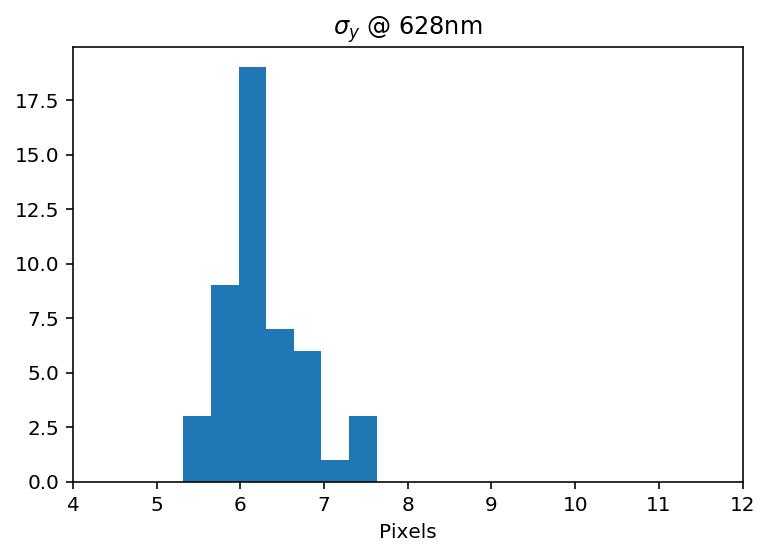

In [54]:
bins = np.arange(4, 15, 0.33)
plt.hist((ResR1[:,:,3]).ravel(), bins=bins)
plt.xlim(4, 12)
plt.title('$\sigma_y$ @ 628nm');
plt.xlabel('Pixels')
savefig('R Sigma Y');

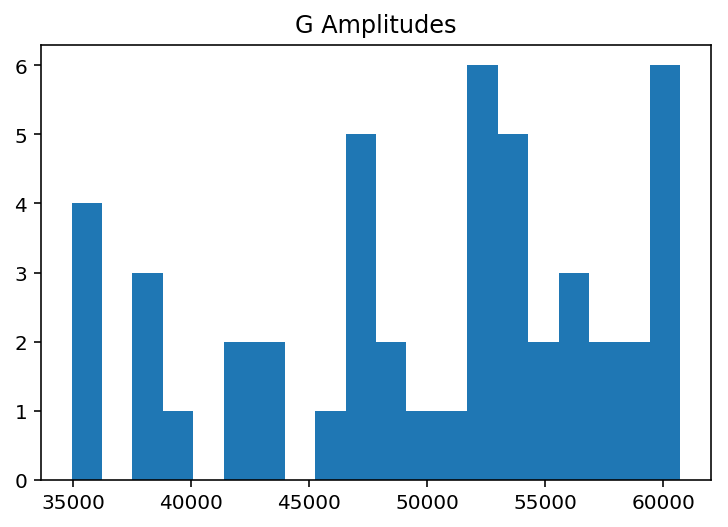

In [55]:
plt.hist(Res[:,:,-1].ravel()*1e-3, bins=20)
plt.title('G Amplitudes');

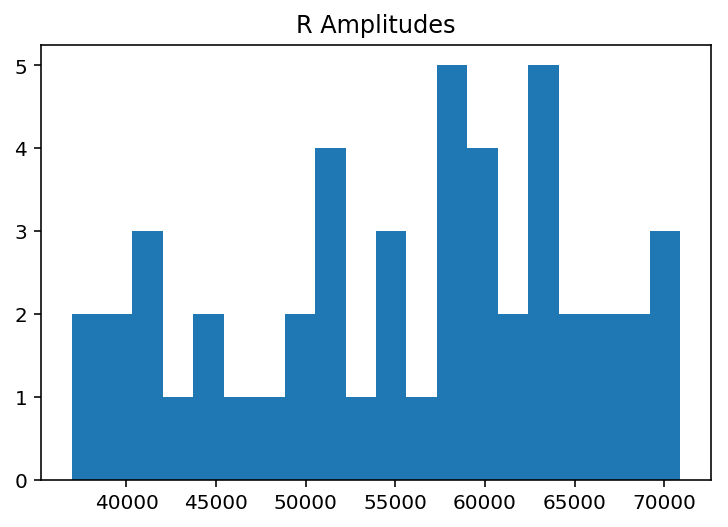

In [56]:
plt.hist(ResR[:,:,-1].ravel()*1e-3, bins=20)
plt.title('R Amplitudes');

# Heatmaps

## Intensity 

Use intensity to visualize the center of the laser beam with respect to the optical axis. 

In [57]:
ip = 8 
amplraw = Res1[:,:,ip] / Res1[:,:,ip].max()
amplrawR = ResR1[:,:,ip] / ResR1[:,:,ip].max()

In [58]:
kws = dict(nrows=nrows, ncols=ncols, annot=True, figsize=(ncols+2, nrows))

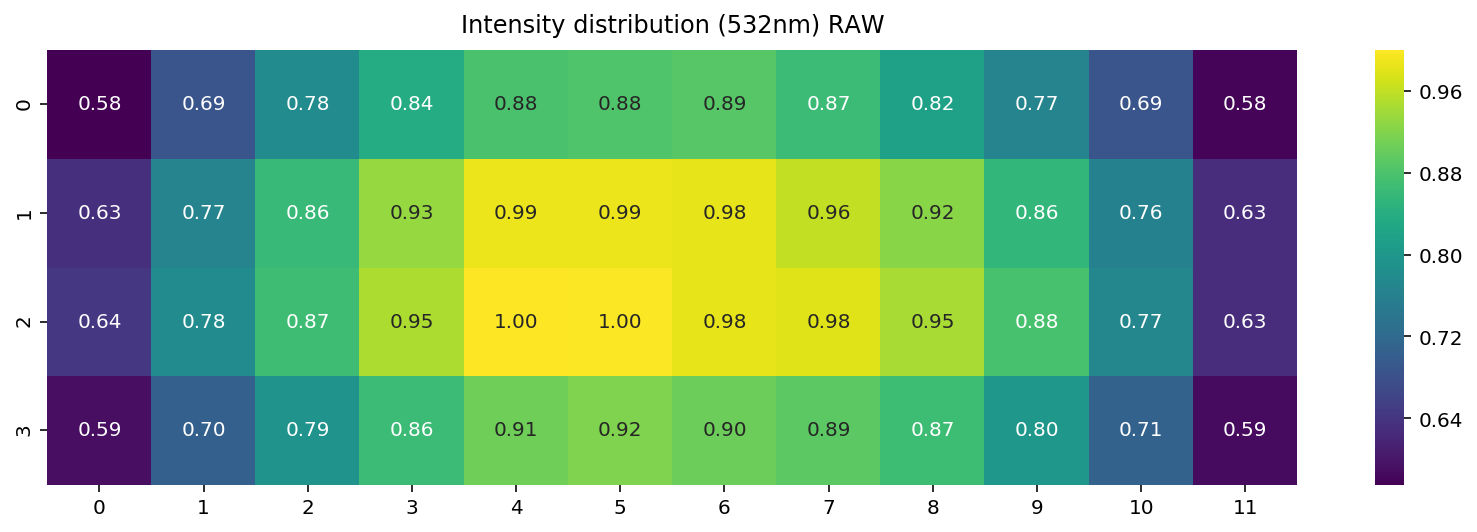

In [59]:
heatmap48(amplraw, title='Intensity distribution (532nm) RAW', fmt='3.2f', **kws)
savefig('G amplitude raw')

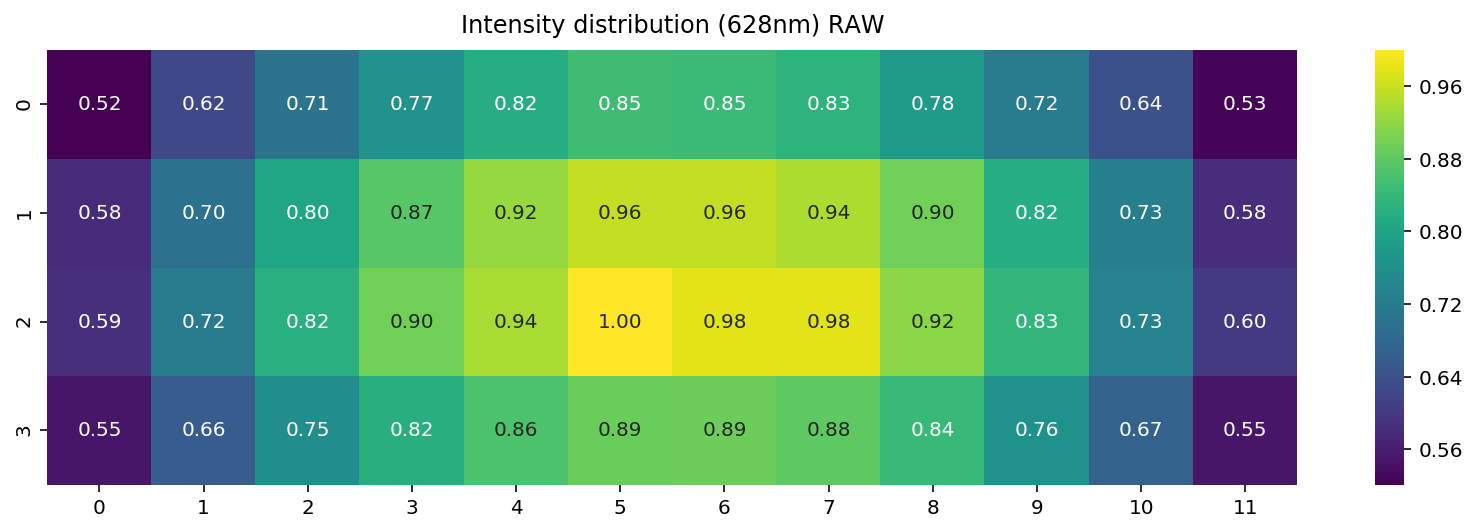

In [60]:
heatmap48(amplrawR, title='Intensity distribution (628nm) RAW', fmt='3.2f', **kws)
savefig('R amplitude raw')

In [61]:
ip = 7
ampl = Res1[:,:,ip] / Res1[:,:,ip].max()
amplR = ResR1[:,:,ip] / ResR1[:,:,ip].max()

In [62]:
# heatmap48(ampl, title='Intensity distribution (532nm) After filter', fmt='3.2f', **kws)
# savefig('G amplitude corr')

In [63]:
# heatmap48(amplR, title='Intensity distribution (628nm) After filter', fmt='3.2f', **kws)
# savefig('R amplitude corr')

## Eccentricity and rotation

Use $\sigma_x \,/\, \sigma_y$ to vizualize LCOS pattern center with respect to the optical axis.
Large rotations indicate a shift toward the optical axis, and small rotations are shifts away from the optical axis.

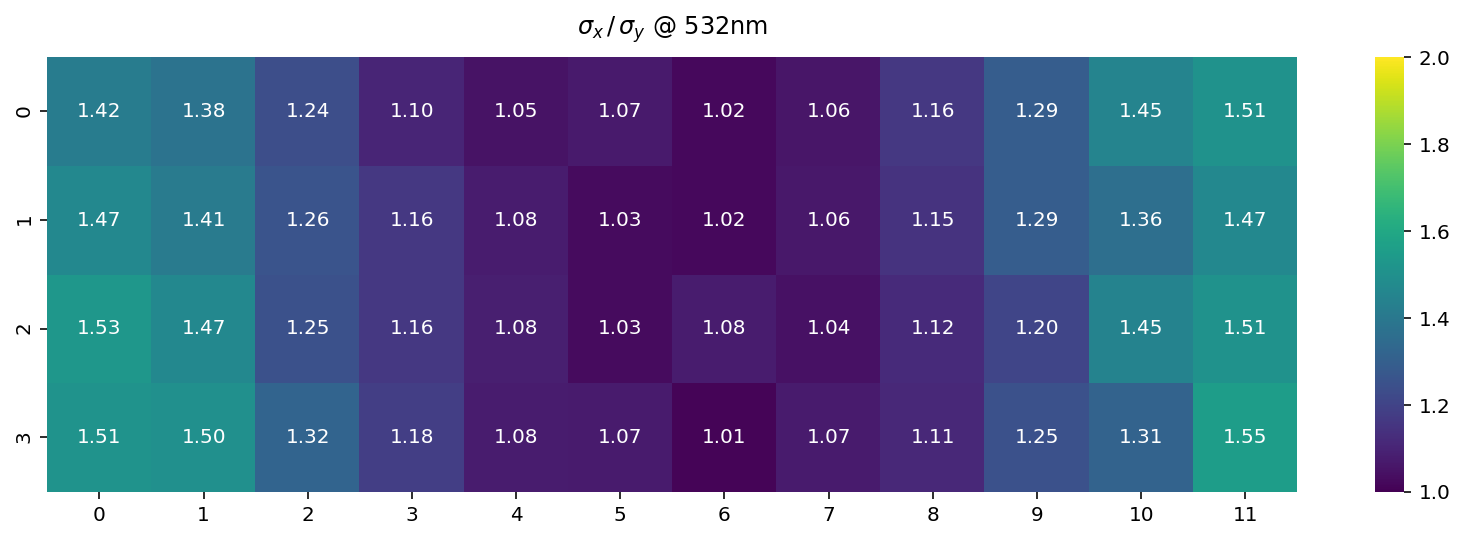

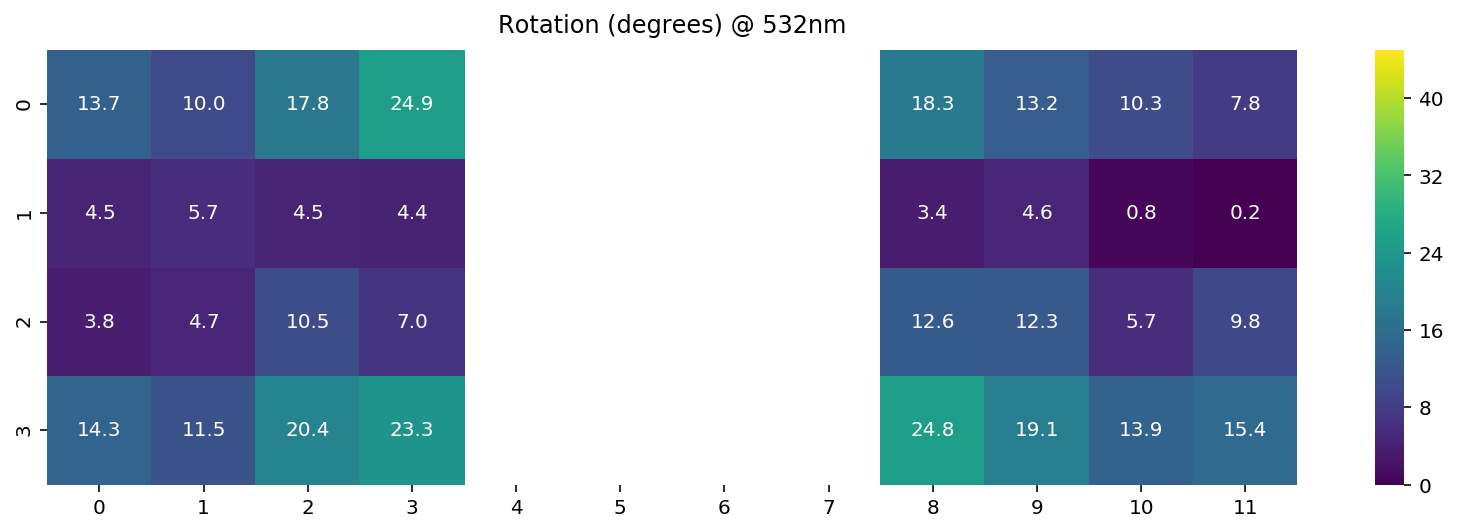

In [64]:
tilt = np.abs(Res1[:,:,4])
tilt[tilt > 45] = 90 - tilt[tilt > 45]
ecc = Res1[:,:,2]/Res1[:,:,3]
heatmap48(ecc, title='$\sigma_x \,/\, \sigma_y$ @ 532nm', vmin=1, vmax=2, fmt='3.2f', **kws)
valid = ecc >= 1.1
heatmap48(tilt, title='Rotation (degrees) @ 532nm', fmt='3.1f', mask=~valid,
          vmin=0, vmax=45, **kws)
savefig('G rotation heatmap')

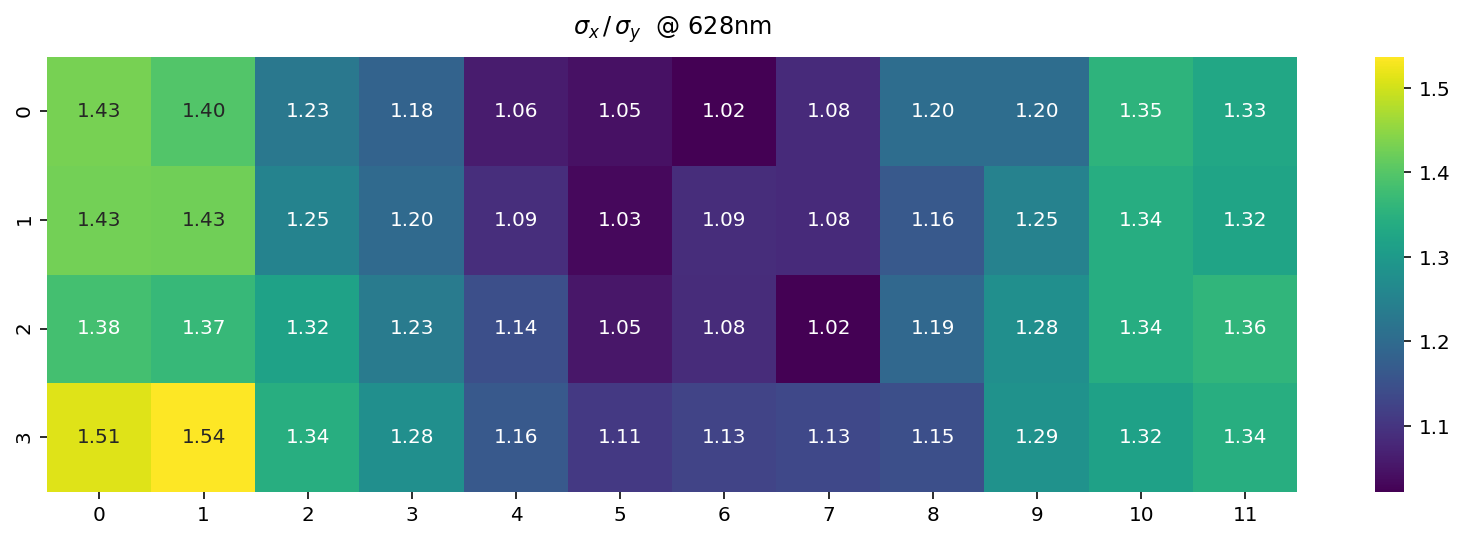

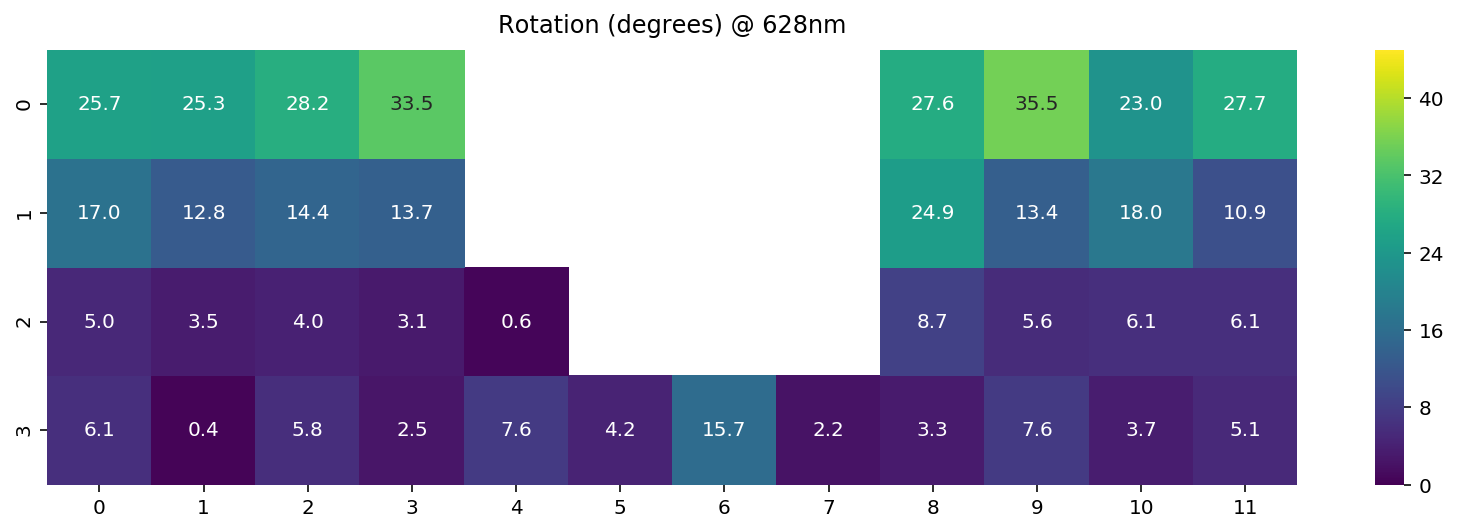

In [65]:
tilt = np.abs(ResR1[:,:,4])
tilt[tilt > 45] = 90 - tilt[tilt > 45]
eccR = ResR1[:,:,2]/ResR1[:,:,3]
heatmap48(eccR, title='$\sigma_x \,/\, \sigma_y$  @ 628nm', fmt='3.2f', **kws)
valid = eccR >= 1.1
heatmap48(tilt, title='Rotation (degrees) @ 628nm', fmt='3.1f', mask=~valid,
          vmin=0, vmax=45, **kws)
savefig('R rotation heatmap')

## Deviation in x and y

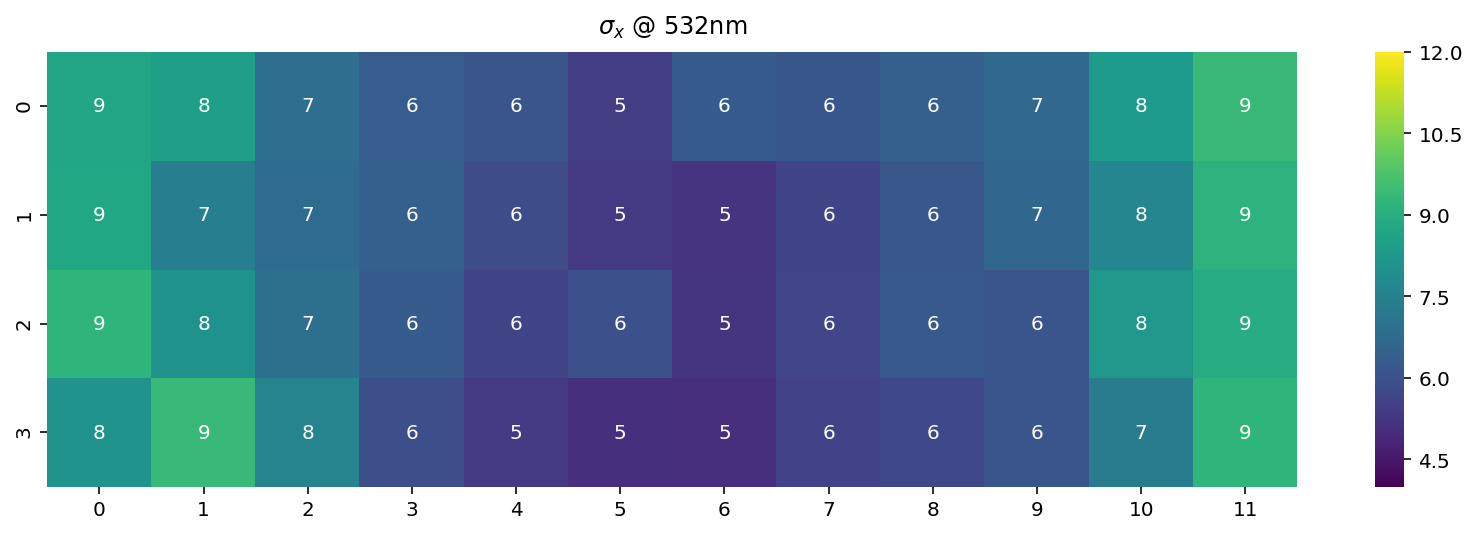

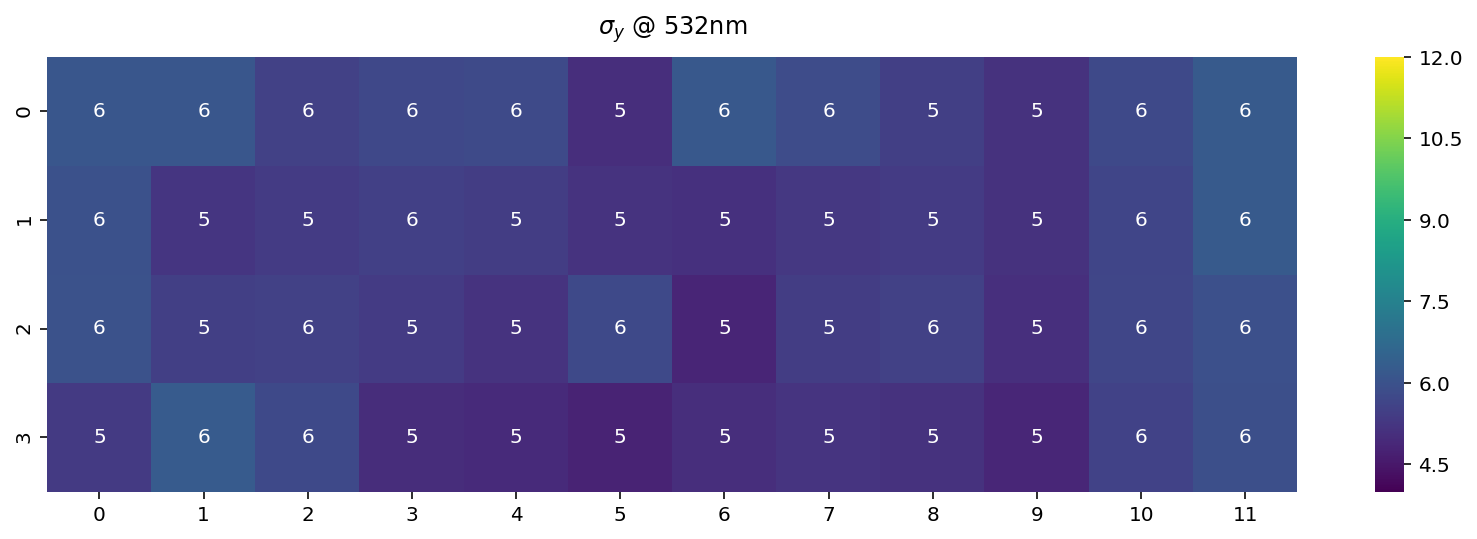

In [66]:
sigmax, sigmay = Res1[:,:,2], Res1[:,:,3]
heatmap48(sigmax, title='$\sigma_x$ @ 532nm', vmin=4, vmax=12, **kws)
savefig('G sigmax heatmap')
heatmap48(sigmay, title='$\sigma_y$ @ 532nm', vmin=4, vmax=12, **kws)

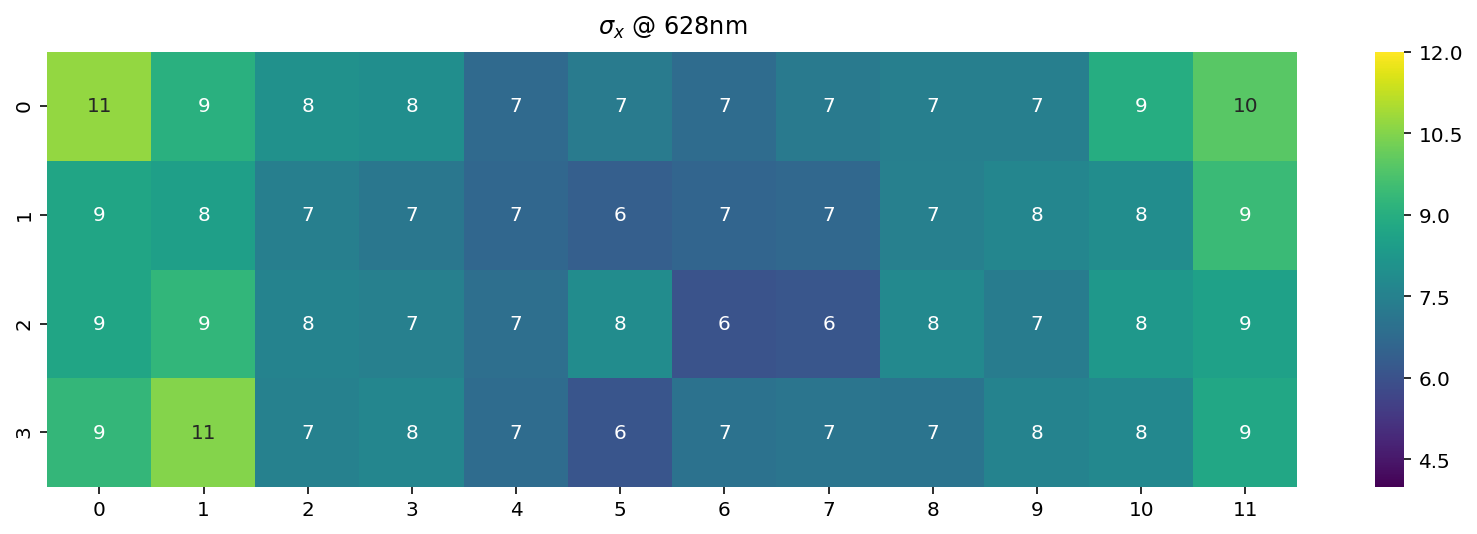

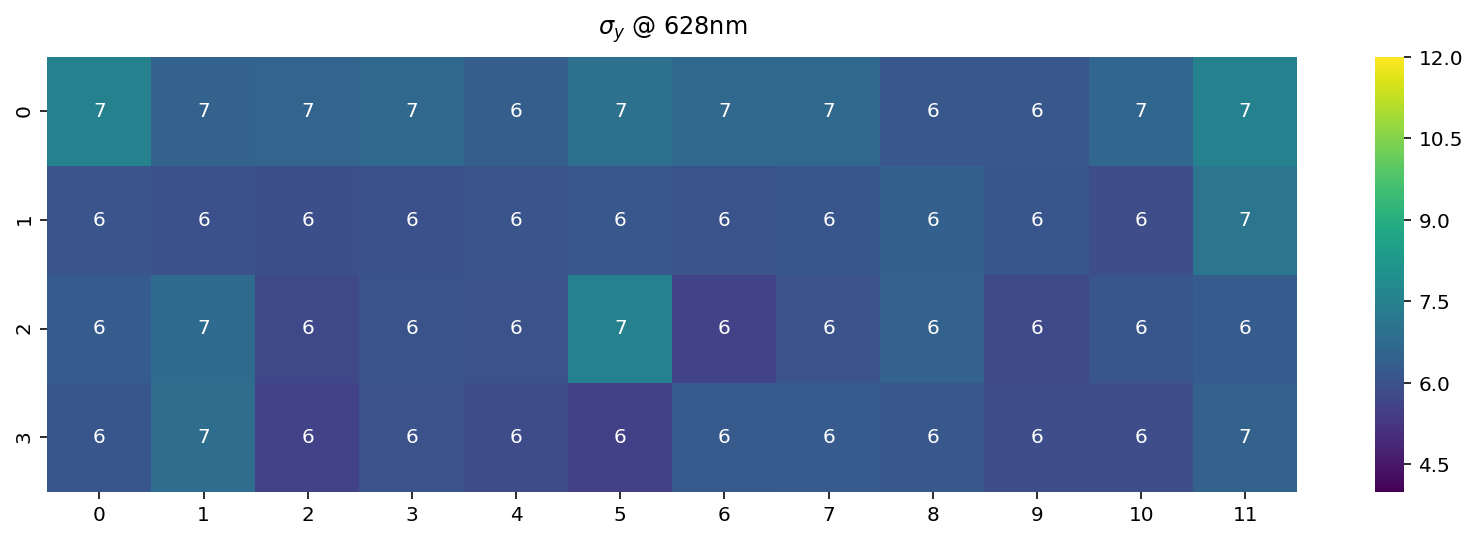

In [67]:
sigmaxR, sigmayR = ResR1[:,:,2], ResR1[:,:,3]
heatmap48(sigmaxR, title='$\sigma_x$ @ 628nm', vmin=4, vmax=12, **kws)
savefig('R sigmax heatmap')
heatmap48(sigmayR, title='$\sigma_y$ @ 628nm', vmin=4, vmax=12, **kws)

## Delta of fitted x,y centers 

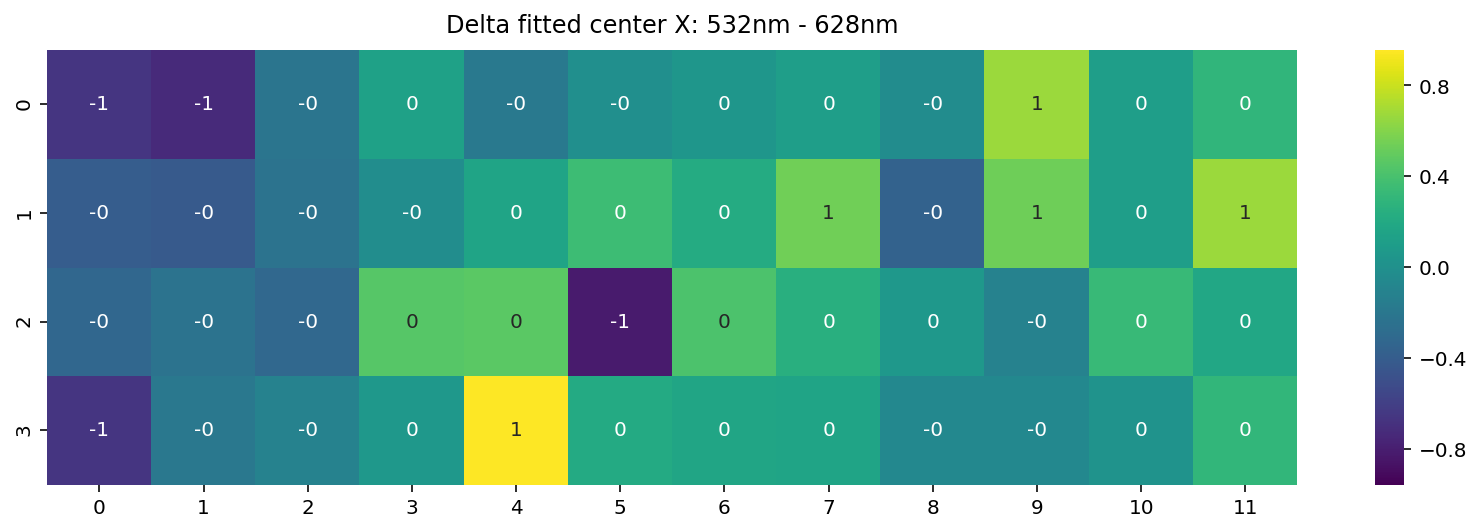

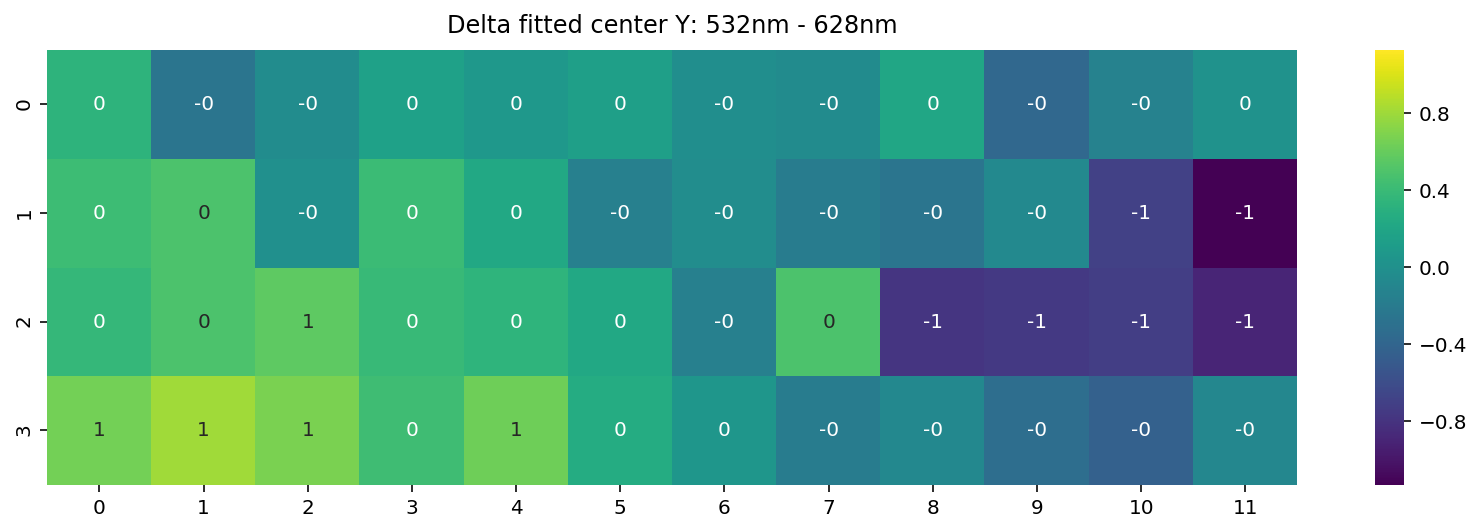

In [68]:
deltax = Res[:,:,0] - ResR[:,:,0]
deltay = Res[:,:,1] - ResR[:,:,1]
heatmap48(deltax, title='Delta fitted center X: 532nm - 628nm', **kws)
heatmap48(deltay, title='Delta fitted center Y: 532nm - 628nm', **kws)

In [69]:
posG = Res[:,:,0:2].copy()
for ix, bx, in enumerate(bounds_lx[:-1]):
    for iy, by in enumerate(bounds_ly[:-1]):
        posG[iy, ix, 0] += bx
        posG[iy, ix, 1] += by
#posG = posG.reshape(48, 2)

In [70]:
posR = ResR[:,:,0:2].copy()
for ix, bx, in enumerate(bounds_lx[:-1]):
    for iy, by in enumerate(bounds_ly[:-1]):
        posR[iy, ix, 0] += bx
        posR[iy, ix, 1] += by
#posR = posR.reshape(48, 2)

# Position and pitch

## Quiver plot

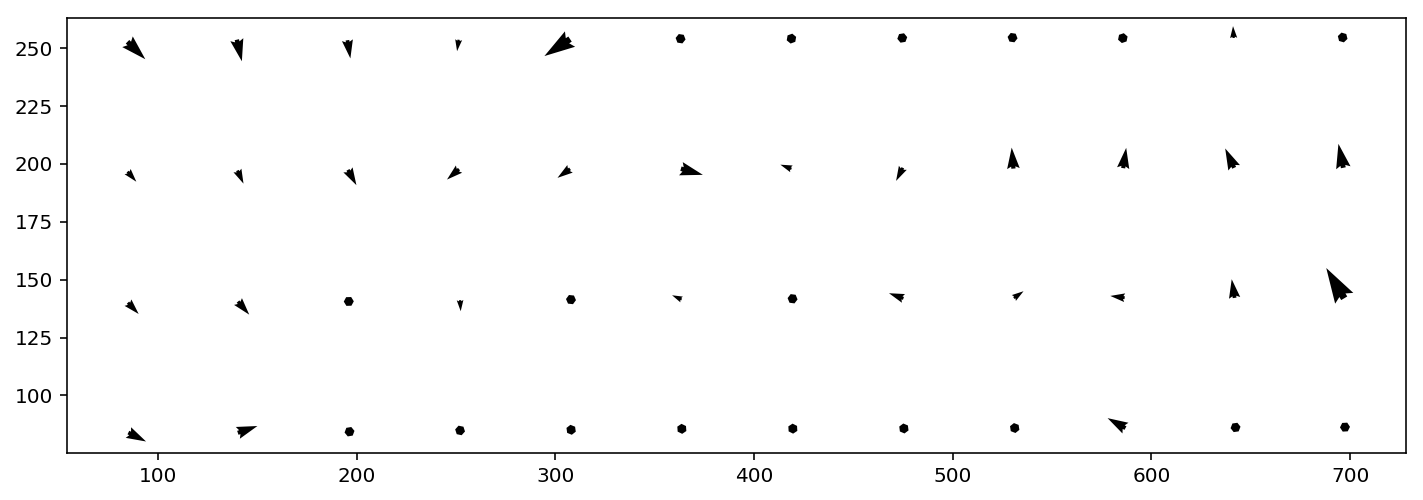

In [71]:
figure()
plt.quiver(posG[:,:,0], posG[:,:,1], posR[:,:,0]-posG[:,:,0], posR[:,:,1]-posG[:,:,1], scale=50)
savefig('delta_alignment_quiver')

## Scatter plot

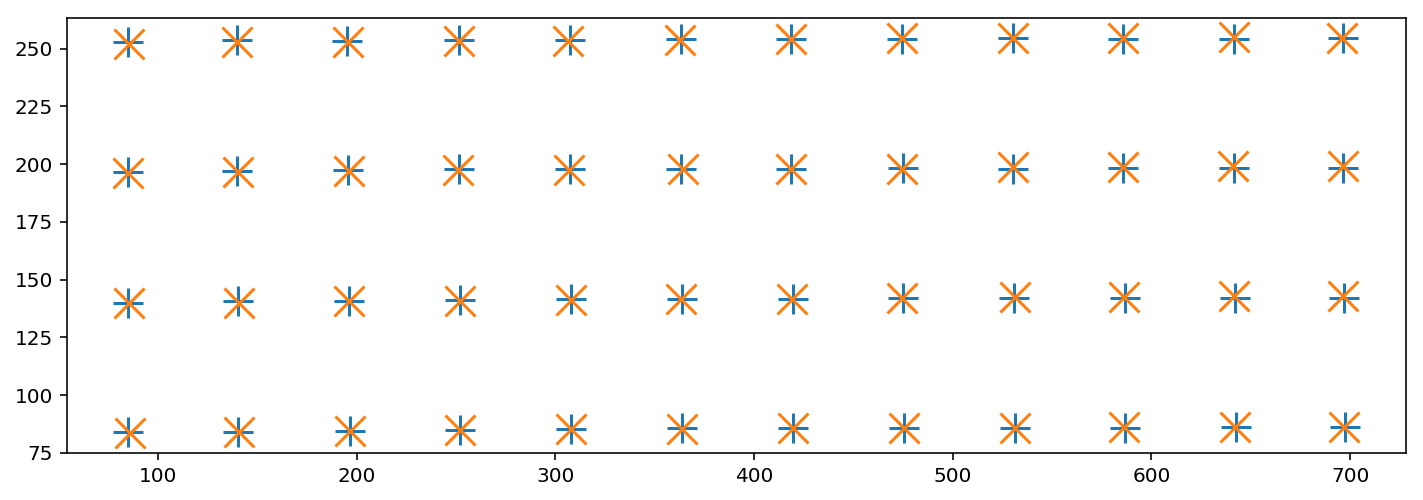

In [72]:
figure()
plt.plot(posG[:,:,0].ravel(), posG[:,:,1].ravel(), ms=15, marker='+', lw=0, mew=1.5)
plt.plot(posR[:,:,0].ravel(), posR[:,:,1].ravel(), ms=15, marker='x', lw=0, mew=1.5)
savefig('delta_alignment_scatter')

In [73]:
posG.shape

(4, 12, 2)

In [74]:
G_mean_pos = posG.mean(axis=0).mean(axis=0)
R_mean_pos = posR.mean(axis=0).mean(axis=0)
G_mean_pos, R_mean_pos

(array([ 391.06233123,  169.60422419]), array([ 391.02374735,  169.58274609]))

In [75]:
G_mean_pitch_x = np.diff(posG[:, :, 0], axis=1).mean()
G_mean_pitch_y = np.diff(posG[:, :, 1], axis=0).mean()
R_mean_pitch_x = np.diff(posR[:, :, 0], axis=1).mean()
R_mean_pitch_y = np.diff(posR[:, :, 1], axis=0).mean()

(G_mean_pitch_x, G_mean_pitch_y), (R_mean_pitch_x, R_mean_pitch_y)

((55.64666896737112, 56.207706034194743),
 (55.567082568305551, 56.142494147219381))

# Finding new R LCOS configuration

Previous is conf1. Here determining conf4:

In [76]:
R_LCOS_pitch_h = 23.01
R_LCOS_pitch_v = 22.56
R_LCOS_center_h = 10.21
R_LCOS_center_v = 19.71

In [77]:
R_LCOS_pix_v = R_mean_pitch_x/R_LCOS_pitch_v
R_LCOS_pix_h = R_mean_pitch_y/R_LCOS_pitch_h
(R_LCOS_pix_h, R_LCOS_pix_v)

(2.4399171728474305, 2.4630799010773741)

New X and Y pitch for **R LOCS**:

In [78]:
G_mean_pitch_y/R_mean_pitch_y * R_LCOS_pitch_h

23.036727090452526

In [79]:
G_mean_pitch_x/R_mean_pitch_x * R_LCOS_pitch_v

22.592311740691301

New center positions for **R LOCS**:

In [80]:
(G_mean_pos[0] - R_mean_pos[0])

0.038583871215905674

In [81]:
(G_mean_pos[1] - R_mean_pos[1])

0.021478096003505698

In [82]:
(G_mean_pos[0] - R_mean_pos[0]) / R_LCOS_pix_v

0.015664888174772053

In [83]:
R_LCOS_center_v + (G_mean_pos[0] - R_mean_pos[0]) / R_LCOS_pix_v

19.725664888174773

In [84]:
R_LCOS_center_h - (G_mean_pos[1] - R_mean_pos[1]) / R_LCOS_pix_h

10.201197202822078